# Dataset Split Generator — Step 5

**Goal:**  
Create *patient-disjoint* training and validation splits for the processed dataset,  
ensuring no data leakage and maintaining approximately an 80/20 balance by **patch count**.

---

### What this notebook does
1. Loads patch metadata from the processed dataset.  
2. Computes how many patches belong to each patient.  
3. Selects train/val patients to achieve ~80/20 patch ratio.  
4. Saves train/val split files (`train.csv`, `val.csv`) under `/splits`.  
5. Prints balance and sanity checks.


### Table of Contents
- [Step 1 — Load paths and patch metadata](#step1)
- [Step 2 — Patch Extraction and Label Generation](#step2)
- [Step 3 — Visual Inspection of Generated Patches](#step3)
- [Step 4 — Summary and Quality Checks](#step4)
- [Step 5 — Dataset Integrity + Overview](#step5)

<a id="step1"></a>
## Step 1 — Load paths and patch metadata

In [1]:
from pathlib import Path
import pandas as pd

# --- Configuration ---
DATASET_DIR = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/patches_cellvit_p128")
LABELS_DIR = DATASET_DIR / "labels"
SPLITS_DIR = DATASET_DIR / "splits"
SPLITS_DIR.mkdir(exist_ok=True)

# --- Gather patch info ---
patch_paths = sorted(LABELS_DIR.glob("*.csv"))
records = []

for f in patch_paths:
    stem = f.stem
    # Extract patient ID (before first underscore)
    patient_id = stem.split("_")[0]
    records.append({"patient": patient_id, "patch": stem})

df = pd.DataFrame(records)
print(f"Total patches found: {len(df)}")
print(f"Unique patients: {df['patient'].nunique()}")
display(df.head())


Total patches found: 4871
Unique patients: 85


,patient,patch
0,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_0_0
1,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_0_128
2,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_0_256
3,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_0_384
4,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_0_512


<a id="step2"></a>
## Step 2 — Compute per-patient patch counts

Total patches: 4871
Patch count per patient:


patient
TCGA-B9-A8YI-01Z-00-DX1      269
TCGA-S3-AA11-01Z-00-DX1      227
TCGA-E9-A22B-01Z-00-DX1      223
TCGA-D8-A1X5-01Z-00-DX2      212
TCGA-BH-A18T-01Z-00-DX1      202
                            ... 
TCGA-J4-A67Q-01Z-00-DX1-5      2
TCGA-YL-A9WY-01Z-00-DX1-5      2
TCGA-G9-6342-01Z-00-DX1-1      1
TCGA-J4-A67T-01Z-00-DX1-3      1
TCGA-KK-A59X-01Z-00-DX1-3      1
Length: 85, dtype: int64

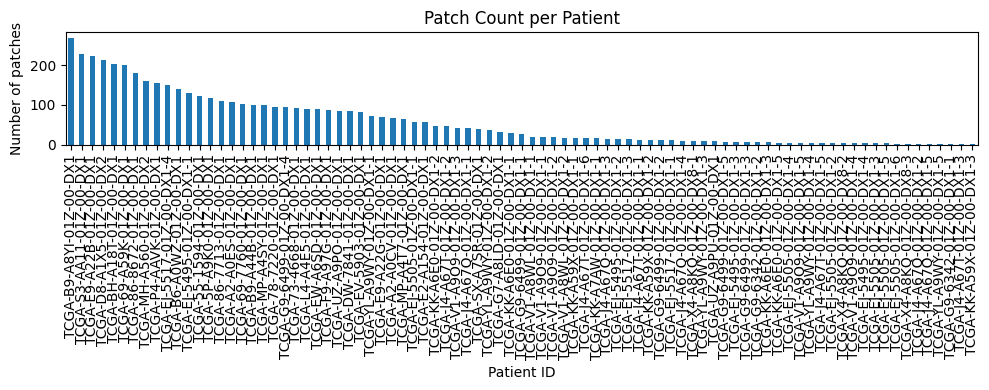

In [2]:
patient_patch_counts = df.groupby("patient").size().sort_values(ascending=False)
total_patches = patient_patch_counts.sum()

print(f"Total patches: {total_patches}")
print("Patch count per patient:")
display(patient_patch_counts)

# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
patient_patch_counts.plot(kind="bar")
plt.title("Patch Count per Patient")
plt.xlabel("Patient ID")
plt.ylabel("Number of patches")
plt.tight_layout()
plt.show()


<a id="step3"></a>
## Step 3 — Patient-level 80/20 patch-balanced split

In [3]:
# Greedy accumulation by patch count until ~80% total
target_train = 0.8 * total_patches
cumulative = 0
train_patients = []

for patient, count in patient_patch_counts.items():
    if cumulative < target_train:
        train_patients.append(patient)
        cumulative += count
    else:
        break

val_patients = [p for p in patient_patch_counts.index if p not in train_patients]

train_ratio = cumulative / total_patches
val_ratio = 1 - train_ratio

print(f"Train patients: {len(train_patients)} | Validation patients: {len(val_patients)}")
print(f"Approx patch ratio → Train: {train_ratio:.1%}, Val: {val_ratio:.1%}")


Train patients: 30 | Validation patients: 55
Approx patch ratio → Train: 81.1%, Val: 18.9%


<a id="step4"></a>
## Step 4 — Save train/val patch lists

In [ ]:
train_patches = df[df["patient"].isin(train_patients)]["patch"]
val_patches   = df[df["patient"].isin(val_patients)]["patch"]

train_patches.to_csv(SPLITS_DIR / "train.csv", index=False, header=False)
val_patches.to_csv(SPLITS_DIR / "val.csv", index=False, header=False)

print(f"Saved train.csv ({len(train_patches)} patches) and val.csv ({len(val_patches)} patches) under {SPLITS_DIR}")


Saved train.csv (3949 patches) and val.csv (922 patches) under /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/patches_cellvit_p128/splits


<a id="step5"></a>
## Step 5 — Verify patch and class balance


Patch distribution summary:
Train patches: 3949 (81.1%)
Val patches:   922 (18.9%)


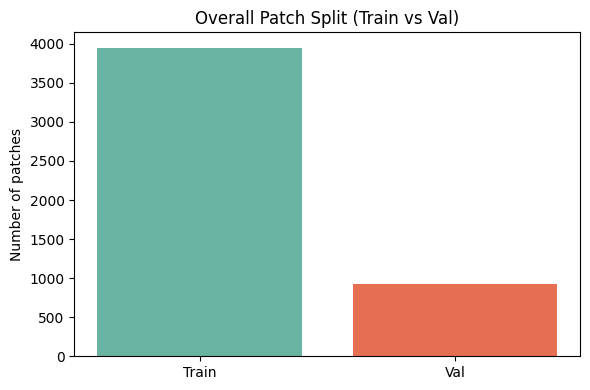

In [5]:
# Quick counts
train_counts = df[df["patient"].isin(train_patients)]["patient"].value_counts()
val_counts   = df[df["patient"].isin(val_patients)]["patient"].value_counts()

print("\nPatch distribution summary:")
print(f"Train patches: {len(train_patches)} ({train_ratio:.1%})")
print(f"Val patches:   {len(val_patches)} ({val_ratio:.1%})")

plt.figure(figsize=(6,4))
plt.bar(["Train", "Val"], [len(train_patches), len(val_patches)], color=["#69b3a2", "#e76f51"])
plt.ylabel("Number of patches")
plt.title("Overall Patch Split (Train vs Val)")
plt.tight_layout()
plt.show()


In [6]:
import csv
from pathlib import Path

def create_types_csv(images_path: str | Path, tissue_type: str = "Lung") -> Path:
    """
    Create a types.csv file listing image names and their tissue type.
    
    Parameters
    ----------
    images_path : str or Path
        Path to the directory containing .png images (e.g., .../train/images).
    tissue_type : str, default="Lung"
        Tissue type to assign to all entries.
    
    Returns
    -------
    Path
        Path to the created CSV file (.../types.csv)
    """
    images_path = Path(images_path)
    assert images_path.is_dir(), f"❌ Given path does not exist or is not a directory: {images_path}"

    csv_path = images_path.parent / "types.csv"
    image_files = sorted([f.name for f in images_path.glob("*.png")])

    if not image_files:
        print(f"⚠️ No .png files found in {images_path}")
        return None

    with open(csv_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["img", "type"])
        for img in image_files:
            writer.writerow([img, tissue_type])

    print(f"✅ Created {csv_path.name} with {len(image_files)} entries.")
    return csv_path


Copy and create a new with _pannuke at the end, rename the imag

Created fold0, then moved images, labels and patch_label_maps under it, 

Then renamed labels -> csv_labels, and patch_label_maps -> labels 

then ran the cells below

In [8]:
images_dir = Path(str(DATASET_DIR) + "_pannuke/fold0/images")
create_types_csv(images_dir, "Lung")

✅ Created types.csv with 4871 entries.


PosixPath('/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/patches_cellvit_p128_pannuke/fold0/types.csv')

# Create fold1 using fold0

In [9]:
import pandas as pd
import shutil
from pathlib import Path
import csv

# --- Config ---
PROJECT_ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis")
PROC_ROOT = PROJECT_ROOT / "ProcessedDataset/v1_40x_area20_2"
PATCH_ROOT = PROC_ROOT / "patches_cellvit_p128_pannuke"

# --- Paths ---
split_file = PATCH_ROOT / "splits" / "val.csv"
fold0_images = PATCH_ROOT / "fold0" / "images"
fold0_labels = PATCH_ROOT / "fold0" / "labels"
fold0_types = PATCH_ROOT / "fold0" / "types.csv"

fold1_root = PATCH_ROOT / "fold1"
fold1_images = fold1_root / "images"
fold1_labels = fold1_root / "labels"
fold1_images.mkdir(parents=True, exist_ok=True)
fold1_labels.mkdir(parents=True, exist_ok=True)

print(f"📂 Creating validation fold under: {fold1_root}")

# --- 1️⃣ Load validation split ---
if not split_file.exists():
    raise FileNotFoundError(f"❌ Split file not found: {split_file}")

val_df = pd.read_csv(split_file, header=None)
val_images = set(val_df[0].astype(str))
print(f"Found {len(val_images)} validation entries.")

# --- 2️⃣ Copy images & labels ---
copied = 0
for img_name in val_images:
    src_img = fold0_images / f"{img_name}.png"
    src_lbl = fold0_labels / f"{img_name}.npy"  # segmentation labels are .npy
    dst_img = fold1_images / src_img.name
    dst_lbl = fold1_labels / src_lbl.name

    if not src_img.exists():
        print(f"⚠️ Missing image: {src_img.name}")
        continue

    if not src_lbl.exists():
        print(f"⚠️ Missing label: {src_lbl.name}")
        continue

    shutil.copy(src_img, dst_img)
    shutil.copy(src_lbl, dst_lbl)
    copied += 1

print(f"✅ Copied {copied} image/label pairs to fold1.")

# --- 3️⃣ Create types.csv for fold1 ---
fold1_types = fold1_root / "types.csv"
with open(fold1_types, "w", newline="") as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["img", "type"])
    for img in sorted(val_images):
        writer.writerow([f"{img}.png", "Lung"])

print(f"✅ Created {fold1_types.name} with {len(val_images)} entries.")


📂 Creating validation fold under: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/patches_cellvit_p128_pannuke/fold1
Found 922 validation entries.
✅ Copied 922 image/label pairs to fold1.
✅ Created types.csv with 922 entries.


In [10]:
from pathlib import Path
import os

# --- Paths ---
PATCH_ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/patches_cellvit_p128_pannuke")

fold0_images = PATCH_ROOT / "fold0" / "images"
fold0_labels = PATCH_ROOT / "fold0" / "labels"
fold1_images = PATCH_ROOT / "fold1" / "images"

# --- Gather filenames ---
fold1_stems = {p.stem for p in fold1_images.glob("*.png")}
fold0_imgs = list(fold0_images.glob("*.png"))
fold0_lbls = list(fold0_labels.glob("*.npy"))

# --- Safety check ---
print(f"🧹 Cleaning overlaps: {len(fold1_stems)} val patches will be removed from fold0...")

removed_imgs, removed_lbls = 0, 0

for img_path in fold0_imgs:
    if img_path.stem in fold1_stems:
        os.remove(img_path)
        removed_imgs += 1

for lbl_path in fold0_lbls:
    if lbl_path.stem in fold1_stems:
        os.remove(lbl_path)
        removed_lbls += 1

print(f"✅ Removed {removed_imgs} images and {removed_lbls} labels from fold0.")


🧹 Cleaning overlaps: 922 val patches will be removed from fold0...
✅ Removed 922 images and 922 labels from fold0.


In [11]:
#Checking if everything is in place

from pathlib import Path
import pandas as pd

# --- Paths ---
PATCH_ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/patches_cellvit_p128_pannuke")

fold0_images = PATCH_ROOT / "fold0" / "images"
fold0_labels = PATCH_ROOT / "fold0" / "labels"
fold1_images = PATCH_ROOT / "fold1" / "images"
fold1_labels = PATCH_ROOT / "fold1" / "labels"
split_file = PATCH_ROOT / "splits" / "val.csv"

print("🔍 Checking dataset structure consistency...\n")

# --- Load split info ---
val_df = pd.read_csv(split_file, header=None)
val_list = set(val_df[0].astype(str))

# --- Gather all file names ---
fold0_imgs = {p.stem for p in fold0_images.glob("*.png")}
fold0_lbls = {p.stem for p in fold0_labels.glob("*.npy")}
fold1_imgs = {p.stem for p in fold1_images.glob("*.png")}
fold1_lbls = {p.stem for p in fold1_labels.glob("*.npy")}

# --- Basic counts ---
print(f"Fold0 (train): {len(fold0_imgs)} images, {len(fold0_lbls)} labels")
print(f"Fold1 (val):   {len(fold1_imgs)} images, {len(fold1_lbls)} labels")
print(f"Val split CSV: {len(val_list)} entries\n")

# --- Check consistency ---
missing_lbls_train = fold0_imgs - fold0_lbls
missing_lbls_val   = fold1_imgs - fold1_lbls

if missing_lbls_train:
    print(f"⚠️ Train images missing labels: {len(missing_lbls_train)}")
else:
    print("✅ All train images have matching labels.")

if missing_lbls_val:
    print(f"⚠️ Val images missing labels: {len(missing_lbls_val)}")
else:
    print("✅ All val images have matching labels.")

# --- Check uniqueness & overlap ---
overlap = fold0_imgs & fold1_imgs
if overlap:
    print(f"⚠️ Found {len(overlap)} overlapping image names between folds!")
else:
    print("✅ No overlap between training and validation folds.")

# --- Check val.csv correctness ---
val_only_in_fold1 = val_list - fold1_imgs
extra_in_fold1 = fold1_imgs - val_list

if val_only_in_fold1:
    print(f"⚠️ {len(val_only_in_fold1)} entries listed in val.csv but missing in fold1.")
if extra_in_fold1:
    print(f"⚠️ {len(extra_in_fold1)} extra images found in fold1 not listed in val.csv.")
if not val_only_in_fold1 and not extra_in_fold1:
    print("✅ fold1 matches val.csv exactly.\n")

# --- Final summary ---
print("📊 Summary:")
print(f"  Total unique patches: {len(fold0_imgs | fold1_imgs)}")
print(f"  Train/Val ratio: {len(fold0_imgs)} / {len(fold1_imgs)} ≈ {len(fold0_imgs)/max(len(fold1_imgs),1):.1f}x")


🔍 Checking dataset structure consistency...

Fold0 (train): 3949 images, 3949 labels
Fold1 (val):   922 images, 922 labels
Val split CSV: 922 entries

✅ All train images have matching labels.
✅ All val images have matching labels.
✅ No overlap between training and validation folds.
✅ fold1 matches val.csv exactly.

📊 Summary:
  Total unique patches: 4871
  Train/Val ratio: 3949 / 922 ≈ 4.3x
